In [5]:
import sys
sys.path.insert(0, '..')

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
from skimage.measure import label,regionprops
from skimage.transform import rescale

import dognet
import torch
from torch.autograd import Variable
from skimage.draw import circle

### Load collman small dataset

This dataset has only three channels: Synapsin, vGlut and PSD-95, rescaled to fit Weiler14 resolution.

In [2]:
collman = np.load('../datasets/collman15/collman_small.npy')

In [3]:
def inference(net,image):
    x = np.expand_dims(image,0)
    vx = Variable(torch.from_numpy(x).float()).cuda()
    res,_ = net(vx)
    return res.data.cpu().numpy()

def make_labels(img,xs,ys,radius=2):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(yv,xv,radius)
        labels[rr,cc]=1
    return labels

def load_annotation(path,scale):
    anno = np.load(path)['collman15v2_annotation']
    
    layer = []
    for i in range(anno.shape[0]):
        props = regionprops(anno[i])
        yy = [p.centroid[0] * scale for p in props]
        xx = [p.centroid[1] * scale for p in props]
        layer.append([xx, yy])
    return layer

### Load of the annotation and making a training set

In [4]:
layer = load_annotation('../datasets/collman15/collman15v2_annotation.npz',2.23e-9/1e-7)

#Train set
train_images = []
train_labels = []
for i in range(9,14):
    d = make_labels(collman[:,0],layer[i][0],layer[i][1])
    train_images.append(collman[:,i-2:i+2].mean(axis=1))
    train_labels.append(d)

### Training DoGNet on Collman15

with CUDA
(tensor([ 159.6516], device='cuda:0'), (10, 1, 64, 64), 4096, 244.0, 1.0)
<function soft_dice_loss at 0x7f9386f7a758>
Training started!
[====================] 100%
Training finished!


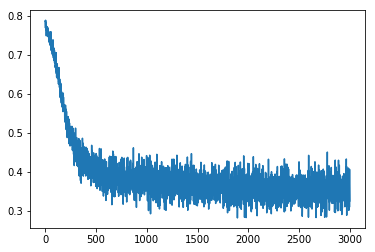

In [6]:
n = dognet.SimpleAnisotropic(3,9,2,return_intermediate=True,learn_amplitude=False)
#n = dognet.DeepIsotropic(3,11,4,4,learn_amplitude=False)
n.weights_init()
if torch.cuda.is_available():
    print('with CUDA')
    n = n.cuda()
else:
    print('CUDA is not detected, running on CPU')
net,errors =dognet.train_routine(n,dognet.create_generator(train_images,train_labels),n_iter=3000,margin=3,loss='softdice',lr=0.001)
plt.plot(errors)

### Plot result on Collman dataset

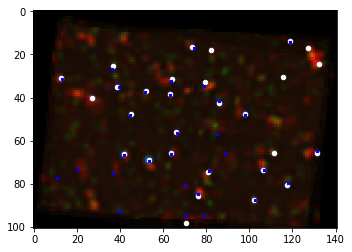

In [7]:
silce = 20

x = collman[:,silce-2:silce+2].mean(axis=1)
y  = inference(net,x)

img = x.transpose((1,2,0))*2.
img = np.dstack( (img, np.ones_like(x[0])*1. ) )
plt.imshow(img)
gt_pts = np.array([layer[silce][0],layer[silce][1]]).transpose(1,0)
coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.3)) if p.area>3])
plt.scatter(coords[:,1],coords[:,0],s=20, c='white', marker='o')
plt.scatter(gt_pts[:,0],gt_pts[:,1],s=7, c='blue', marker='x')

### Load Weiler dataset 

The repacked dataset contains only 'Ex3R43C2_Synapsin1_3', 'Ex3R43C2_vGluT1_2', 'Ex3R43C2_PSD95_2' channels for 3 first slices.

In [7]:
weiler = np.load('../datasets/weiler14/weiler.npz')['weiler']

In [8]:
# Domain shift to fit collman statistics

new_weiler = []
for i in range(3):
    frag = collman[i,0,20:80,20:100]
    intfrag = weiler[i,0,300:900,350:900]
    k = (np.std(frag)/np.std(intfrag))
    shift = (np.mean(frag)-np.mean(intfrag))
    wfrag = intfrag*k+shift
    
    domain_shift = []
    for j in range(weiler.shape[1]):
        domain_shift.append(weiler[i,j]*k+shift)
        
    new_weiler.append(np.stack(domain_shift))
new_weiler = np.stack(new_weiler)

In [9]:
from matplotlib.patches import Rectangle,Ellipse
from scipy.io import savemat
sample = np.mean(new_weiler[:,:,300:500,700:900],axis=1)
res = inference(net,sample.astype(float))
xx,yy,_ = dognet.find_peaks(res[0,0],3)

#Extract descriptors
syn = dognet.extract_descriptor(sample[0],
                                xx,yy,window_size=3,get_gaussian=dognet.get_gaussian)
psd = dognet.extract_descriptor(sample[2],
                                xx,yy,window_size=3,get_gaussian=dognet.get_gaussian)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))


plt.setp(axes, xticks=[], yticks=[])
samplex = np.copy(np.transpose(sample,(1,2,0)))
samplex[samplex>0.5]=0.5
samplex = (samplex-np.min(samplex,(0,1)))/(np.max(samplex,(0,1))-np.min(samplex,(0,1))).astype(np.float)
axes.imshow(samplex,interpolation='bilinear')

for s,p in zip(syn,psd):
    axes.arrow(s[0],s[1], p[0]-s[0], p[1]-s[1], head_width=2., head_length=2., fc='y', ec='y')


NameError: name 'net' is not defined

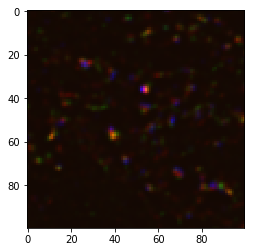

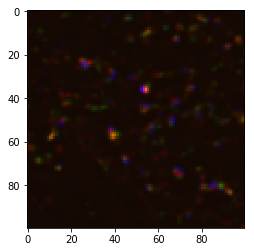

In [12]:
annotation = sio.loadmat('../datasets/weiler14/weiler300400_800900.mat')
plt.imshow(np.array(annotation["RGB_image"]))
plt.figure()
plt.imshow(np.array(np.mean(new_weiler[:,:3,300:400,800:900],axis=1).transpose(2,1,0)).astype(np.float))

### Estimate F1 score with expert annotation

In [11]:
from scipy.io import loadmat

annotations = ['../datasets/weiler14/weiler300400_400500.mat',
               '../datasets/weiler14/weiler300400_800900.mat']

for a in annotations[1:]:
    annotation = loadmat(a)
    #img = np.array(np.mean(new_weiler[:,:,300:400,800:900],axis=1).transpose(2,1,0)).astype(np.float)
    img = np.array(np.mean(new_weiler[:,:3,200:500,800:900],axis=1).transpose(2,1,0)).astype(np.float)
    res = inference(net,img.transpose(2,0,1))
    
    xx,yy,_ = dognet.find_peaks(res[0,0],3)
    
    gt_pts = np.array([[x,y] for x,y in zip(annotation["X"][0,1:]-1.+100,annotation["Y"][0,1:]-1.)])
    #coords = np.array([ list(p.centroid) for p in regionprops(label(res[0,0]>0.5)) if p.area>0])
    #dog_pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)
    dog_pts = np.array([yy,xx]).transpose(1,0)
    precision,recall,f1_score,_ = dognet.get_metric(gt_pts,dog_pts,s=4.)
    
    print(f1_score)
    
    syn = dognet.extract_descriptor(img[:,:,0],
                                xx,yy,window_size=3,get_gaussian=dognet.get_gaussian)
    psd = dognet.extract_descriptor(img[:,:,2],
                                xx,yy,window_size=3,get_gaussian=dognet.get_gaussian)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    plt.setp(axes, xticks=[], yticks=[])
    axes.imshow(res[0,0],interpolation='bilinear',cmap='gray')
    plt.savefig("weiler14_prob.png", bbox_inches='tight', pad_inches = 0 ,dpi=300)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    plt.setp(axes, xticks=[], yticks=[])
    
    from matplotlib_scalebar.scalebar import ScaleBar
    scalebar = ScaleBar(1e-7,color = 'white',box_alpha=0.0)
    axes.add_artist(scalebar)

    img = np.copy(img)
    #print(img.shape)
    img[img>0.5]=0.5
    img = (img-np.min(img,(0,1)))/(np.max(img,(0,1))-np.min(img,(0,1))).astype(np.float)
    axes.imshow(img,interpolation='bilinear')
    plt.savefig("weiler14_org.png", bbox_inches='tight', pad_inches = 0 ,dpi=300)
    axes.scatter(gt_pts[:,0],gt_pts[:,1],s=100,marker='x',color='w',zorder=20)
    #axes.scatter(yy,xx,s=50,marker='x',color='red',zorder=20)
    
    for s,p in zip(syn,psd):
        axes.arrow(s[0],s[1], p[0]-s[0], p[1]-s[1], head_width=3.5, head_length=3.5, fc='r', ec='r')
        
    rect = Rectangle((100,0), 99, 99,fill=False,
                 edgecolor="yellow",linestyle='--',lw=3)
    axes.add_artist(rect)    
    plt.savefig("weiler14_loc.png", bbox_inches='tight', pad_inches = 0 ,dpi=300)

NameError: name 'net' is not defined

In [51]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

gen = dognet.create_generator(train_images,train_labels)

from dognet.baselines.convnets import Direct,FCN,U_net

pd.options.display.float_format = '{:,.2f}'.format

nin=3
baselines = [Direct(nin), FCN(nin), U_net(nin,4)] 


deepdogs = [dognet.SimpleIsotropic(nin,15,5), 
            dognet.SimpleAnisotropic(nin,15,5),  
            dognet.DeepIsotropic(nin,15,5),
            dognet.DeepAnisotropic(nin,15,5)]


def estimate(net,th=3):
    img = np.array(np.mean(new_weiler[:,:3,300:400,800:900],axis=1).transpose(2,1,0)).astype(np.float)
    res = inference(net,img.transpose(2,0,1))
    y_gt = make_labels(res[0],annotation["X"][0,1:]-1,annotation["Y"][0,1:]-1.)
    xx,yy,_ = dognet.find_peaks(res[0,0],3)
    pts = np.array([yy,xx]).transpose(1,0)
    gt_pts = np.array([[x,y] for x,y in zip(annotation["X"][0,1:]-1.,annotation["Y"][0,1:]-1.)])
    prec,rec,f1,_ = dognet.get_metric(gt_pts,pts,s=3)
    fpr, tpr, thresholds = roc_curve( y_gt.flatten(),res[0,0].flatten())  
    return f1,prec,rec,auc(fpr, tpr),abs(float(pts.shape[0])-float(gt_pts.shape[0]))

def run_benchmark(networks,name,gen,nrun=0):
    result = []
    for n in networks:
        net,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=5,lr=0.001,loss='softdice',verbose=False)
        result.append([net.__class__,dognet.get_n_params(net)]+list(estimate(net)))
    df = pd.DataFrame(result)
    df.columns = ['name','#','f1','precision','recall','auc','|dic|']
    df.to_csv('weiler_results_{}_{}.csv'.format(name,nrun))
    print(df)
 
for nrun in range(5):
    run_benchmark(baselines+deepdogs,"all",gen,nrun)


                                          name     #   f1  precision  recall  \
0   <class 'dognet.baselines.convnets.Direct'>  3392 0.73       0.81    0.67   
1      <class 'dognet.baselines.convnets.FCN'>  3002 0.74       0.85    0.66   
2    <class 'dognet.baselines.convnets.U_net'>   622 0.81       0.85    0.77   
3    <class 'dognet.networks.SimpleIsotropic'>    62 0.86       0.81    0.92   
4  <class 'dognet.networks.SimpleAnisotropic'>   107 0.87       0.85    0.88   
5      <class 'dognet.networks.DeepIsotropic'>   140 0.86       0.81    0.92   
6    <class 'dognet.networks.DeepAnisotropic'>   230 0.82       0.85    0.79   

   auc  |dic|  
0 0.89   6.00  
1 0.91   8.00  
2 0.88   3.00  
3 0.98   3.00  
4 0.94   1.00  
5 0.94   3.00  
6 0.93   2.00  
                                          name     #   f1  precision  recall  \
0   <class 'dognet.baselines.convnets.Direct'>  3392 0.77       0.81    0.73   
1      <class 'dognet.baselines.convnets.FCN'>  3002 0.73       0.81   

In [52]:
csvs = [pd.read_csv('weiler_results_all_{}.csv'.format(i)) for i in range(5)]
df_concat = pd.concat(csvs)
df_concat.groupby(level=0).mean()

,Unnamed: 0,#,f1,precision,recall,auc,|dic|
0,0,3392,0.74,0.81,0.67,0.88,5.80
1,1,3002,0.70,0.82,0.61,0.91,9.60
2,2,622,0.79,0.88,0.71,0.86,6.60
3,3,62,0.84,0.82,0.86,0.96,2.20
4,4,107,0.83,0.87,0.79,0.93,3.40
5,5,140,0.85,0.79,0.93,0.89,4.20
6,6,230,0.79,0.85,0.74,0.90,4.20


(0.6428571428571429, 0.6666666666666666, 0.6206896551724138, 0.4415632024103339, 2.0)


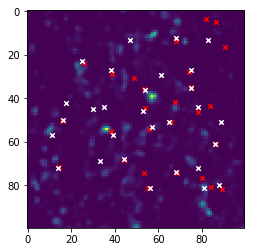

In [30]:
img = np.array(np.mean(new_weiler[:,:3,300:400,800:900],axis=1)).astype(np.float)
y_gt = make_labels(img,annotation["X"][0,1:]-1,annotation["Y"][0,1:]-1.)
gt_pts = np.array([[x,y] for x,y in zip(annotation["X"][0,1:]-1.,annotation["Y"][0,1:]-1.)])

r = dognet.cellprofiler_pipeline([img[0]],[img[1]],8)
r = (r-r.min())/(r.max()-r.min())
plt.imshow(r)
xx,yy,_ = dognet.find_peaks(r,3,minval=0.12)
pts = np.array([xx,yy]).transpose(1,0)
    
fpr, tpr, thresholds = roc_curve( y_gt.flatten(),r.flatten())

prec,rec,f1,_ = dognet.get_metric(gt_pts,pts,s=3)
print(f1,prec,rec,auc(fpr, tpr),abs(float(pts.shape[0])-float(gt_pts.shape[0])))

plt.scatter(gt_pts[:,0],gt_pts[:,1],s=20,c='r',marker='x',zorder=10)  
plt.scatter(xx,yy,s=20,c='w',marker='x',zorder=10)  

(0.6567164179104479, 0.8148148148148148, 0.55, 0.5508923792108695, 13.0)


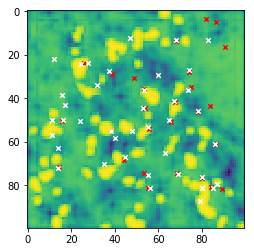

In [43]:
img = np.array(np.mean(new_weiler[:,:3,300:400,800:900],axis=1)).astype(np.float)
y_gt = make_labels(img,annotation["X"][0,1:]-1,annotation["Y"][0,1:]-1.)
gt_pts = np.array([[x,y] for x,y in zip(annotation["X"][0,1:]-1.,annotation["Y"][0,1:]-1.)])


    
#Simhal
prob = 1.-dognet.baselines.probabilistic_synapse_segmentation(img,img,max_size=5,
                                                              window_size=3,conf_threshold=0.76, base_threshold=0.01)
r = (prob-prob.min())/(prob.max()-prob.min())
plt.imshow(r[0])

fpr, tpr, thresholds = roc_curve( y_gt.flatten(),r[0].flatten())
xx,yy,_ = dognet.find_peaks(r[0],4,minval=0.9)
pts = np.array([xx,yy]).transpose(1,0)
#print(pts.shape,gt_pts.shape)
prec,rec,f1,_ = dognet.get_metric(gt_pts,pts,s=4)
fpr, tpr, thresholds = roc_curve( y_gt.flatten(),r[0].flatten())
print(f1,prec,rec,auc(fpr, tpr),abs(float(pts.shape[0])-float(gt_pts.shape[0])))
#plt.imshow(rep31_anno[0].image[0])
plt.scatter(gt_pts[:,0],gt_pts[:,1],s=20,c='r',marker='x',zorder=10)  
plt.scatter(xx,yy,s=20,c='w',marker='x',zorder=10)  

### Descriptor export

In [22]:
import pandas as pd
from skimage.io import imsave
name = 'weiler'
req_channels=['Ex3R43C2_Synapsin1_3', 'Ex3R43C2_vGluT1_2', 'Ex3R43C2_PSD95_2']
dm=[]
for silce in range(1,2):
    x = new_weiler[:,silce-2:silce+2].mean(axis=1).astype(np.float32)
    y  = inference(net,x)
    xx,yy,_ = dognet.find_peaks(y[0,0],3)
    
    imsave("../results/weiler_prob_"+str(silce)+".png",y[0,0])
    pic = x[:3].transpose(1,2,0)
    
    pic = np.copy(pic)
    pic[pic>0.5]=0.5
    pic = (pic-np.min(pic,(0,1)))/(np.max(pic,(0,1))-np.min(pic,(0,1))).astype(np.float)
    for x,y in zip(xx,yy):
        x = int(x)
        y = int(y)
        pic[x-1:x+2,y,0]=1
        pic[x-1:x+2,y,1]=1
        pic[x-1:x+2,y,2]=0
        pic[x,y-1:y+2,0]=1
        pic[x,y-1:y+2,1]=1
        pic[x,y-1:y+2,2]=0
    imsave("../results/weiler_loc_"+str(silce)+".png",pic)
    for c in range(len(req_channels)):    
            desc = dognet.extract_descriptor(weiler[c,silce-2:silce+2].mean(axis=0),xx,yy,3)   
            dm+=[[silce,req_channels[c]]+d for d in desc]
            
dm = np.array(dm)            
d = {'fov': dm[:,0] , 'marker': dm[:,1],'x': dm[:,2] ,'y': dm[:,3] ,'A': dm[:,4] ,'L1': dm[:,5]
     ,'L2': dm[:,6] ,'sigmax2': dm[:,7],'sigmay2': dm[:,8],'sigmaxy': dm[:,9],'angle': dm[:,10],
     'x_dog': dm[:,11],'y_dog': dm[:,12]}
df = pd.DataFrame(data=d)
df.to_csv(name+".csv")